In [2]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss,normalized_mutual_info_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, log_loss, f1_score,recall_score,fbeta_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import random
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import PredefinedSplit
import eval_plots as val
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer,fbeta_score

# import seaborn as sns


### 1:9 data set

In [3]:
data_jan=pd.read_csv('Jan_data.csv',index_col=0)

In [4]:
scaled_data_feb=pd.read_csv('Feb_data.csv',index_col=0)

In [5]:
x_train=data_jan.drop(columns=['is_churn'])
y_train=data_jan.is_churn

In [48]:
scaled_data_feb.is_churn.value_counts()

0    301734
1     33526
Name: is_churn, dtype: int64

In [6]:
val_churn=scaled_data_feb[scaled_data_feb['is_churn']==1][:10000]
val_not_churn=scaled_data_feb[scaled_data_feb['is_churn']==0][:90000]
val=pd.concat([val_churn,val_not_churn])
x_val=val.drop(columns='is_churn')
y_val=val.is_churn

In [7]:
test_churn=scaled_data_feb[scaled_data_feb['is_churn']==1][10000:]
test_not_churn=scaled_data_feb[scaled_data_feb['is_churn']==0][90000:]
test=pd.concat([test_churn,test_not_churn])
x_test=test.drop(columns='is_churn')
y_test=test.is_churn

### regular data

In [4]:
data_jan=pd.read_csv('Finalfinalfinalfinal_Jan.csv',index_col=0).drop(columns=['membership_expire_date','date_max'])

In [5]:
data_feb=pd.read_csv('Finalfinalfinalfinal_Feb.csv',index_col=0).drop(columns=['membership_expire_date','date_max'])

In [6]:
x_jan_all=data_jan.drop(columns=['is_churn'])
y_jan_all=data_jan.is_churn

In [7]:
x_feb_all=data_feb.drop(columns=['is_churn'])
y_feb_all=data_feb.is_churn

## Scaling without smote

In [4]:
data_jan = data_jan.reindex(columns=(list([a for a in data_jan.columns if a != 'is_churn']) +['is_churn'] ))
data_feb = data_feb.reindex(columns=(list([a for a in data_feb.columns if a != 'is_churn']) +['is_churn'] ))

scaler = preprocessing.StandardScaler()
scaled_data_jan = scaler.fit_transform(data_jan.iloc[:,:-1])
scaled_data_jan = pd.DataFrame(scaled_data_jan,columns=data_jan.columns[:-1])
scaled_data_jan['is_churn']=data_jan.is_churn.values.astype(int)
scaled_data_jan=scaled_data_jan.set_index([data_jan.index])

scaled_data_feb = scaler.transform(data_feb.iloc[:,:-1])
scaled_data_feb = pd.DataFrame(scaled_data_feb,columns=data_feb.columns[:-1])
scaled_data_feb['is_churn']=data_feb.is_churn.values.astype(int)
scaled_data_feb=scaled_data_feb.set_index([data_feb.index])


In [5]:
scaled_data_feb.shape

(638352, 81)

In [6]:
scaled_data_feb.is_churn.value_counts()

0    604826
1     33526
Name: is_churn, dtype: int64

In [7]:
y_train=scaled_data_jan.is_churn
x_train=scaled_data_jan.drop(columns=['is_churn'])

### With Smote Subselect Feature + resampling

In [6]:
drop_x_column=['secs_std_14d',
 'percent_whole_song_60d',
 '30d_percent_25',
 'total_secs_7d',
 'percentage_length_30d',
 'unq_mean_14d',
 'percent_whole_song_30d',
 '3060_uniq_diff',
 'secs_std_7d',
 'percent_unique_7d',
 'percentage_length_14d',
 'percent_whole_song_14d',
 'unq_mean_7d',
 'percentage_length_7d',
 '3060_listen_days_diff',
 'percent_whole_song_7d',
 'listening_days_60d',
 'listening_days_30d',
 '1430_listen_diff',
 'listening_days_14d',
 'last_day',
 'listening_days_7d',
 '90_payment_plan_days_sum',
 '90_count_transaction',
 '90_payment_plan_days_mean',
 '30_is_cancel_sum',
 '90_is_cancel_sum',
 'quick_churn',
 'registered_via_13','is_churn']

In [7]:
jan_x_sub = data_jan.drop(drop_x_column,1)
jan_y_sub = data_jan['is_churn']

feb_x_sub = data_feb.drop(drop_x_column,1)
feb_y_sub = data_feb['is_churn']

smote=SMOTE(random_state=110,n_jobs=-1)
X_bal_sub,y_bal_sub=smote.fit_resample(jan_x_sub,jan_y_sub)

scaler = preprocessing.StandardScaler()
X_bal_sub = scaler.fit_transform(X_bal_sub)
X_test_sub = scaler.transform(feb_x_sub)

y_bal_sub=y_bal_sub.values.astype(int)
y_test_sub=feb_y_sub.values.astype(int)

# smote + subfeature
# jan: X_bal_sub,y_bal_sub; Feb:X_test_sub,y_test_sub

In [8]:
Y_bal_sub=y_bal_sub.reshape(1340532,1)
train_data_sub=np.concatenate((X_bal_sub, Y_bal_sub), axis=1)
train_res_sub = resample(train_data_sub,replace=False,n_samples=280000,random_state=123)
x_res_sub=train_res_sub[:,:-1]
y_res_sub=train_res_sub[:,-1]

# jan resample 280000:
# jan: x_res_sub,y_res_sub


In [9]:
x_res_sub_val=X_test_sub[:180000]
y_res_sub_val=y_test_sub[:180000]

x_res_sub_test=X_test_sub[180000:]
y_res_sub_test=y_test_sub[180000:]

# feb resample 180000:
# val: x_res_sub_val,y_res_sub_val
# test: x_res_sub_test,y_res_sub_test

In [ ]:
#(X_bal_sub,y_bal_sub,x_res_sub_val,y_res_sub_val,x_res_sub_test,y_res_sub_test)

### With SMOTE

In [206]:

jan_x = data_jan.drop('is_churn',1)
jan_y = data_jan['is_churn']

feb_x = data_feb.drop('is_churn',1)
feb_y = data_feb['is_churn']

smote=SMOTE(random_state=110,n_jobs=-1)
X_bal,y_bal=smote.fit_resample(jan_x,jan_y)

scaler = preprocessing.StandardScaler()
X_bal = scaler.fit_transform(X_bal)
X_test = scaler.transform(feb_x)

y_bal=y_bal.values.astype(int)
y_test=feb_y.values.astype(int)

# train: X_bal,y_bal
# test: X_test,y_test

In [9]:
# X_train,X_cv,y_train,y_cv=train_test_split(X_bal,y_bal,test_size=0.3,random_state=110,stratify=y_bal)

####  Random resample with SMOTE

In [18]:
Y_bal=y_bal.reshape(1340532,1)
train_data=np.concatenate((X_bal, Y_bal), axis=1)
train_res = resample(train_data,replace=True,n_samples=280000,random_state=123)
x_res=train_res[:,:-1]
y_res=train_res[:,-1]

####  Random resample

In [14]:
train_resample = resample(data_jan, n_samples=280000, replace=False, stratify=None)
x_train_res=train_resample.drop(columns=['is_churn'])
y_train_res=train_resample['is_churn']


In [15]:
val_resample = resample(data_feb, n_samples=280000, replace=False, stratify=None)
x_val_res=val_resample.drop(columns=['is_churn'])
y_val_res=val_resample['is_churn']


## Get test lgbm

In [18]:
def plotAUC(truth, pred):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label=' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")

In [9]:
f2_score=make_scorer(fbeta_score,beta=2)

In [21]:
def get_test_auc(x_train,y_train,x_val,y_val,x_test,y_test):
    
    
    lgb = LGBMClassifier(n_jobs=-1)

    param = {
               
        
        
        
        
        
                'learning_rate':[0.001,0.005,0.01,0.02,0.03,0.05,0.08,0.1,0.12,0.15,0.2,0.25,0.3,0.6],
                'boosting_type':['gbdt','dart','goss'],
                'num_leaves':[10,20,30,40,50,60,70,80,90],
                'max_bin':[10,20,30,50,80,100,200,250,300,350,400,450,500,800,1000,2000],
                'num_iterations':[50,100,150,200,250,300],
                'max_depth':[-1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
#               'min_child_samples':[2,5,8,10,15,20,25,30,50,70,100,200],
#               'bagging_fraction':[0.5,0.8,0.9,1],
                'feature_fraction':[0.2,0.3,0.4,0.5,0.6,0.7,0.8],
                'n_estimators':[50,100,150,200,250,300,400,500],
                'scale_pos_weight':[1,2,3,4,5,6,7,8,9,10,11,12,13]


               }

    X=np.concatenate((x_train,x_val),axis=0)
    y=np.concatenate((y_train,y_val),axis=0)
    
    split_index = [-1]*len(y_train)+[0]*len(y_val)
    pds = PredefinedSplit(test_fold = split_index)
    
    random_clf = RandomizedSearchCV(lgb,n_iter=500,scoring=f2_score,param_distributions=param, cv=pds, verbose=1, n_jobs=-1)
    random_clf.fit(X,y)
    best_param_1 = random_clf.best_params_
    
    start_1 = datetime.now()

    lgb1 = LGBMClassifier(
#                             
                    learning_rate=best_param_1['learning_rate'],
                    objective='binary',
                    metric='binary_logloss',
                    boosting_type=best_param_1['boosting_type'],
                    num_leaves=best_param_1['num_leaves'],
                    max_bin=best_param_1['max_bin'],
                    num_iterations=best_param_1['num_iterations'],
                    max_depth=best_param_1['max_depth'],
#                   min_child_samples=best_param_1['min_child_samples'],
#                   bagging_fraction=best_param_1['bagging_fraction'],
                    n_estimators=best_param_1['n_estimators'],
                    feature_fraction=best_param_1['feature_fraction'],
                    scale_pos_weight=best_param_1['scale_pos_weight'],
                    n_jobs=-1)

    lgb1.fit(x_train,y_train)
    
    
    pred_train= lgb1.predict_proba(x_train)[:,1] 
    pred_train_prob = lgb1.predict_proba(x_train)
    pred_train_2 = lgb1.predict(x_train)
    
    print('Train recall of LGBM-1 = ',recall_score(y_train,pred_train_2))
    print('Train f2 score of LGBM-1 = ',fbeta_score(y_train,pred_train_2,beta=2))
    print("Train Area Under Curve of LGBM-1 = ",roc_auc_score(y_train,pred_train))
    print("Train accuracy of LGBM-1 = ",accuracy_score(y_train,pred_train_2))
    print("Train logloss of LGBM-1 = ",log_loss(y_train,pred_train_prob))
  
    pred_test= lgb1.predict_proba(x_test)[:,1] 
    pred_test_prob = lgb1.predict_proba(x_test)
    pred_test_2 = lgb1.predict(x_test)
    
    print('best_parameter are:',best_param_1)
    print('Test recall of LGBM-1 = ',recall_score(y_test,pred_test_2))
    print('Test f2 score of LGBM-1 = ',fbeta_score(y_test,pred_test_2,beta=2))
    print("Test Area Under Curve of LGBM-1 = ",roc_auc_score(y_test,pred_test))
    print("Test accuracy of LGBM-1 = ",accuracy_score(y_test,pred_test_2))
    print("Test logloss of LGBM-1 = ",log_loss(y_test,pred_test_prob))
    
    pred_test_3 = lgb1.predict(x_val)
    print('Val f2 score of LGBM-1 = ',fbeta_score(y_val,pred_test_3,beta=2))

    
    plotAUC(y_test, pred_test)
    plt.show()
    print("Time taken to train LightGBM Model-1 = ", (datetime.now() - start_1))
    

    return random_clf.cv_results_

Fitting 1 folds for each of 500 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.5min finished


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Train recall of LGBM-1 =  0.6406920060110691
Train f2 score of LGBM-1 =  0.5204053683922213
Train Area Under Curve of LGBM-1 =  0.8092395329153069
Train accuracy of LGBM-1 =  0.8125682659531577
Train logloss of LGBM-1 =  0.4746125782279766
best_parameter are: {'scale_pos_weight': 8, 'num_leaves': 20, 'num_iterations': 150, 'n_estimators': 500, 'max_depth': 10, 'max_bin': 20, 'learning_rate': 0.02, 'feature_fraction': 0.8, 'boosting_type': 'goss'}
Test recall of LGBM-1 =  0.7825384680778713
Test f2 score of LGBM-1 =  0.4322164415979566
Test Area Under Curve of LGBM-1 =  0.6994914736816705
Test accuracy of LGBM-1 =  0.5512454305874351
Test logloss of LGBM-1 =  0.75152594939545
Val f2 score of LGBM-1 =  0.4317738575417756


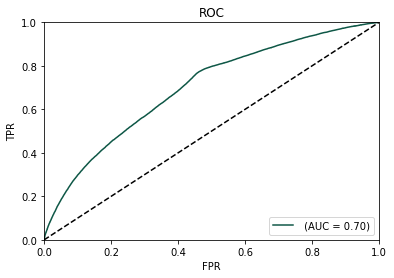

Time taken to train LightGBM Model-1 =  0:00:05.823052


{'mean_fit_time': array([ 43.34323215,   8.79385662,  12.20545578,   9.81258464,
         20.8373251 ,  28.20868301,  10.71974874,  16.42737198,
         26.99153519,  39.10113239,  13.64105606,  19.66987252,
         18.55178523,  33.67955041,   8.79003382,   8.11723971,
         16.91465926,  10.05418754,  30.33884501,  65.08072448,
         14.51428509,  16.19915938,  85.54456186,  35.32154179,
         23.43239927,   7.59722257,  15.48675275,  30.16317296,
         49.52241683,  13.44206905,  85.90628767,  14.85841322,
         21.80905151,  11.83102775,  69.33160686,  28.26225972,
         11.22819257,  17.9565134 ,   8.68782377,  15.52115536,
         12.72411442,  19.77161074,   8.38070726,  18.09891486,
         15.65335464,  10.62912464, 113.71981859,  14.16719246,
          8.87346458,  32.24812961,  11.59346485,   8.87184787,
         80.19984174,  19.29951048,  19.85286403,  14.56680775,
         19.96282125,  12.43178153,  10.83380055,  18.14033365,
         14.00314784,  

In [22]:
get_test_auc(x_train,y_train,x_val,y_val,x_test,y_test)

## Learning curve

In [9]:
def logloss_resampling(train,train_y, test, test_y,nruns, sampsize):
    
    loglosses = []
    
    #Logistic regression
    my_model = LGBMClassifier(n_jobs=-1)
    #fit the models and compute logloss on test data
    for i in range(nruns):
        index_list = np.random.randint(0, len(train), size=sampsize)
        train_samp = train.iloc[index_list]
        y_sample = train_y.iloc[index_list]
        my_model.fit(train_samp,y_sample)
        loglosses.append(log_loss(test_y, my_model.predict_proba(test)[:, 1]))
       
    #Returns the mean(logloss) and SE(logloss)
    return np.mean(loglosses),np.std(loglosses,ddof = 1)/np.sqrt(nruns)

In [11]:
2**19

524288

In [17]:
linspace = [2**(i) for i in range(10,20)]
lg_mean = np.zeros(len(linspace))
lg_se = np.zeros(len(linspace))

#Run 20 resampling
for i,size in enumerate(linspace):
    lg_mean[i],lg_se[i]= logloss_resampling(x_jan_all,y_jan_all,x_feb_all,y_feb_all,30, size)
    print('For sample size {}, The mean logloss is {}.'.format(size,lg_mean[i]))

For sample size 1024, The mean logloss is 0.4794898422374229.
For sample size 2048, The mean logloss is 0.3947671847415422.
For sample size 4096, The mean logloss is 0.2963749390741169.
For sample size 8192, The mean logloss is 0.24558330830635738.
For sample size 16384, The mean logloss is 0.22045964621831898.
For sample size 32768, The mean logloss is 0.219245654552553.
For sample size 65536, The mean logloss is 0.21784702538283732.
For sample size 131072, The mean logloss is 0.2209757235090619.
For sample size 262144, The mean logloss is 0.21442159409303357.
For sample size 524288, The mean logloss is 0.21512100675456455.


Text(0.5, 1.0, 'Mean Logloss and Confidence Interval')

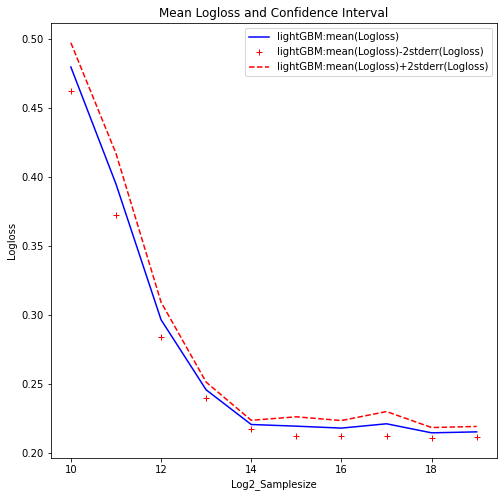

In [19]:
#Make learning curve. plots
plt.figure(figsize = (8,8))
plt.plot(np.log2(linspace),lg_mean,'b',label = 'lightGBM:mean(Logloss)')
plt.plot(np.log2(linspace),lg_mean-2*lg_se,'r+',label = 'lightGBM:mean(Logloss)-2stderr(Logloss)')
plt.plot(np.log2(linspace),lg_mean+2*lg_se,'r--',label = 'lightGBM:mean(Logloss)+2stderr(Logloss)')

plt.legend()
plt.xlabel('Log2_Samplesize')
plt.ylabel('Logloss')
plt.title('Mean Logloss and Confidence Interval')

In [20]:
2**14

16384

In [ ]:
# smote + subfeature
# jan: X_bal_sub,y_bal_sub

# jan resample 280000:
# jan: x_res_sub,y_res_sub


# val: x_res_sub_val,y_res_sub_val
# test: x_res_sub_test,y_res_sub_test

In [ ]:
get_learning_curve(X_bal_sub,x_res_sub_val,y_bal_sub,y_res_sub_val,classifier)

In [57]:
data_jan.shape

(272830, 81)

In [67]:
def get_learning_curve(X,X_Validation,y,y_Validation,classifier):
    linspace=[1024, 2048, 4096, 8192, 12000, 16384, 32768, 
          65536, 80000,100000, 131072,200000, 
          262144]

    dic_size = {}
    for i in linspace:
    
        train_index=np.random.choice(len(y),i, replace=False)
        train = X[train_index, :]
        train_y = y[train_index]
    
        lgb=classifier(n_jobs=-1)
        lgb.fit(train,train_y)
        y_pred=lgb.predict_proba(X_Validation)[:,1]
        dic_size[i] = log_loss(y_Validation,y_pred)
        print('For sample size {}, The logloss is {}.'.format(i,dic_size[i]))
        print(roc_auc_score(y_Validation,y_pred))
    size = pd.DataFrame(list(dic_size.items()),columns = ['Size','Logloss']) 
    plt.figure(figsize = (8,8))
    plt.plot(size['Size'],size['Logloss'],marker='o')
    plt.title('Learning Curve for LGBMClassifier')
    plt.xlabel('Sample Size')
    plt.ylabel('Logloss')
    plt.plot(65536,0.25199645755438527,'r')
    plt.show()

For sample size 1024, The logloss is 0.5598977023739536.
0.6098239566666668
For sample size 2048, The logloss is 0.3996904453804298.
0.5765214700000001
For sample size 4096, The logloss is 0.3538005272789454.
0.6338327344444444
For sample size 8192, The logloss is 0.3268566322654714.
0.6628227311111111
For sample size 12000, The logloss is 0.3685224231622734.
0.6359523033333333
For sample size 16384, The logloss is 0.3514854175857116.
0.6602379005555555
For sample size 32768, The logloss is 0.3084750829322921.
0.6943077733333333
For sample size 65536, The logloss is 0.3201036877423558.
0.6338290877777778
For sample size 80000, The logloss is 0.3640789458684467.
0.5916656338888888
For sample size 100000, The logloss is 0.3431371627552464.
0.5832727388888889
For sample size 131072, The logloss is 0.32041422043065476.
0.6102820205555556
For sample size 200000, The logloss is 0.32804180548228323.
0.6269642894444445
For sample size 262144, The logloss is 0.33391656408140885.
0.6060117377777

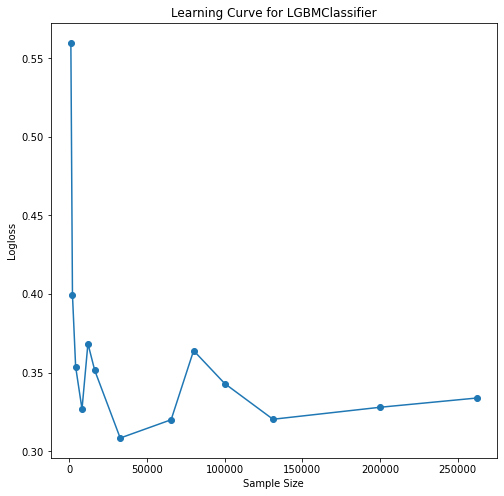

In [59]:
get_learning_curve(x_train.values,x_train.values,y_train.values,y_train.values,LGBMClassifier)

For sample size 1024, The logloss is 0.5405018564580873.
0.6900331961067045
For sample size 2048, The logloss is 0.412120284333497.
0.7025749539333254
For sample size 4096, The logloss is 0.3217592093229927.
0.749207025596741
For sample size 8192, The logloss is 0.28478379607491605.
0.7607348496134028
For sample size 12000, The logloss is 0.27174693969012875.
0.7822886241859638
For sample size 16384, The logloss is 0.2651825015803561.
0.7930683739530905
For sample size 32768, The logloss is 0.25773534227342304.
0.8106999301458993
For sample size 65536, The logloss is 0.2519723691455828.
0.8236302277464441
For sample size 80000, The logloss is 0.2509356983407563.
0.8265112571369073
For sample size 100000, The logloss is 0.24958504771486942.
0.8284581449027677
For sample size 131072, The logloss is 0.2490935494098087.
0.8303277642699327
For sample size 200000, The logloss is 0.24738961679374136.
0.833092617300724
For sample size 262144, The logloss is 0.24669283956457963.
0.8346240609730

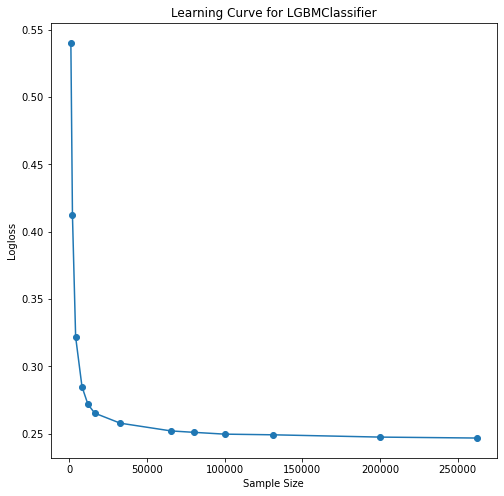

In [68]:
get_learning_curve(x_train.values,x_train.values,y_train.values,y_train.values,LGBMClassifier)